In [1]:
import pandas as pd
import numpy as np
import os, glob, linecache, uuid
import seaborn as sns
import re
import matplotlib.pyplot as plt
from hampel import hampel

sns.set(rc={'figure.figsize':(12, 10)})
uuid_gen = uuid.uuid4()

# Data Read In

In [2]:
data_dir = "C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets/HistoricalWellSynthesis/Data"
#Nimbus Data Dir:
# data_dir = r"N:\Dangermond_Preserve\Sandbox\JElhance_sbx\Data\JLDP_Wells"

In [104]:
full_well_data = pd.read_csv(f"{data_dir}/full_well_data.csv")
full_well_data['datetime'] = pd.to_datetime(full_well_data['datetime'])

E:\Users\jinsu.elhance\AppData\Local\ESRI\conda\envs\arcgeopy\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [105]:
print(f"Full well data contains {full_well_data.shape[0]} rows pre-cleaning")

Full well data contains 2944536 rows pre-cleaning


# Assessing Data Quality

In [106]:
# Looking for duplicate timestamps per well.
dupe_counts = full_well_data.groupby(["well", "datetime"]).agg("count")['level_corrected'].value_counts()

#Looks like many wells have multiple entries. Lets find out if their levels are the same.
# full_well_data.groupby(['well', 'datetime'])['level_corrected'].agg(lambda x: max(x)-min(x))
# full_well_data.loc[full_well_data.level_corrected.isna(), 'level_corrected'] = full_well_data.loc[full_well_data.level_corrected.isna()]['level']

In [107]:
print(f"There are {full_well_data.shape[0] - dupe_counts[1]} records to be resolved")

There are 1412764 records to be resolved


In [108]:
#Drop straight up duplicates
full_well_data = full_well_data.drop_duplicates(subset=['well','datetime','level_corrected'])
print(f"Removed duplicates, down to {full_well_data.shape[0]} rows")

#Dropping rows with neither level nor level corrected
full_well_data = full_well_data.dropna(subset=['level', 'level_corrected'], how='all')

#If there is no level corrected, use level
print(f"Taking original levels for {full_well_data['level_corrected'].isna().sum()} records")
full_well_data.loc[full_well_data['level_corrected'].isna(), 'level_corrected'] = full_well_data.loc[full_well_data['level_corrected'].isna()]['level']

#If an excel file exists, use that level_corrected
num_similar = full_well_data.groupby(['well', 'datetime'])['level_corrected'].transform("count")
has_xlsx = full_well_data.groupby(['well', 'datetime'])['barologger_level'].transform(lambda x: any(x.notna()))
#Drop duplicates with has xlsx and num similar with no barologger level
      
full_well_data = full_well_data.loc[~((num_similar > 1) & (has_xlsx) & (full_well_data.barologger_level.isna()))]
print(f"Removed erroneous corrections, down to {full_well_data.shape[0]} rows")

Removed duplicates, down to 2684958 rows
Taking original levels for 2170 records
Removed erroneous corrections, down to 2223689 rows


In [109]:
well_datetime_diff = full_well_data.groupby(['well', 'datetime'])['level_corrected'].transform(lambda x: max(x)-min(x))

In [110]:
_te = full_well_data.groupby(['well', 'datetime'])['level_corrected'].transform("count")

In [111]:
full_well_data.loc[_te > 1].sort_values(['well', 'datetime'])

,Unnamed: 0,date,time,level,temperature,baro_corrected,temperature_c,temperature_f,well,barologger_level,barologger_level_c_elevation,temperature_barometer_f,level_corrected,groundwater_elevation,datetime,datetime_hr_10min,barologger_level_lompoc,well_altitude_diff,baro_well_altitude_diff,barologger_level_corrected
349532,182882203535190675,2017-08-17 00:00:00,09:36:16.0,74.838500,67.390,False,NaN,67.3900,oaks3b,NaN,NaN,NaN,74.838500,NaN,2017-08-17 09:36:16,2017-08-17 09:3,NaN,-901.201423,-901.201423,NaN
379274,182882203535190675,2017-08-17 00:00:00,09:36:16.0,41.593300,67.390,False,NaN,67.3900,oaks3b,NaN,NaN,NaN,41.593300,NaN,2017-08-17 09:36:16,2017-08-17 09:3,NaN,-901.201423,-901.201423,NaN
349533,-8101456002030811114,2017-08-17 00:00:00,09:51:16.0,74.840000,67.386,False,NaN,67.3860,oaks3b,NaN,NaN,NaN,74.840000,NaN,2017-08-17 09:51:16,2017-08-17 09:5,NaN,-901.201423,-901.201423,NaN
379275,-8101456002030811114,2017-08-17 00:00:00,09:51:16.0,41.594300,67.386,False,NaN,67.3860,oaks3b,NaN,NaN,NaN,41.594300,NaN,2017-08-17 09:51:16,2017-08-17 09:5,NaN,-901.201423,-901.201423,NaN
349534,-1686097314274730695,2017-08-17 00:00:00,10:06:16.0,74.843400,67.382,False,NaN,67.3820,oaks3b,NaN,NaN,NaN,74.843400,NaN,2017-08-17 10:06:16,2017-08-17 10:0,NaN,-901.201423,-901.201423,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648632,4151551939670681707,2018-10-08 00:00:00,04:15:00.0,0.000000,14.000,False,14.0,57.2000,oaks3bbl,NaN,NaN,NaN,0.000000,NaN,2018-10-08 04:15:00,2018-10-08 04:1,NaN,-902.349717,-902.349717,NaN
1701111,19305,2010-05-16,16:15:00,52.862800,NaN,NaN,NaN,61.0034,tinta6,2.6972,2.485336,83.1956,50.377464,NaN,2010-05-16 16:15:00,2010-05-16 16:1,NaN,-159.301793,-159.301793,NaN
1701112,19306,2010-05-16,16:15:00,52.862800,NaN,NaN,NaN,61.0034,tinta6,2.6922,2.480336,82.6970,50.382464,NaN,2010-05-16 16:15:00,2010-05-16 16:1,NaN,-159.301793,-159.301793,NaN
2913438,3760045462948599147,2021/12/05,15:40:54,3.041294,22.289,False,NaN,22.2890,unknown,NaN,34.033605,NaN,-30.992311,NaN,2021-12-05 15:40:54,2021-12-05 15:4,32.182516,-1529.000000,-1529.000000,34.033605


In [112]:
full_well_data = full_well_data[full_well_data.level_corrected != 0]

In [3]:
full_well_data.to_csv(f"{data_dir}/full_well_data_cleaned.csv")
full_well_data = pd.read_csv(f"{data_dir}/full_well_data_cleaned.csv")
full_well_data.datetime = pd.to_datetime(full_well_data.datetime)

E:\Users\jinsu.elhance\AppData\Local\ESRI\conda\envs\arcgeopy\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Coding Baro Correction

In [4]:
full_well_data['baro_correction_code'] = 0 #Unknown Correction
full_well_data.loc[full_well_data.barologger_level.notna(), 'baro_correction_code'] = 1 #Corrected on collection
full_well_data.loc[full_well_data.datetime > pd.to_datetime("2020-01-01"), 'baro_correction_code'] = 2 #Corrected with K7AZ Lompoc Baro-readings (only post 2020)

# Selecting Columns

In [5]:
full_well_data = full_well_data[["well", "datetime", "level", "level_corrected", "temperature", "temperature_c", "temperature_f", "barologger_level", "barologger_level_c_elevation", "temperature_barometer_f", "barologger_level_lompoc", "baro_correction_code"]]

## Moving into per-well cleaning

In [6]:
finished_wells = [
    "tinta3bl",
    "escondido1",
    "oaks3bbl",
    "tinta5b"
]

In [7]:
full_well_data['outlier'] = False
for well in full_well_data.well.unique():
    well_data = full_well_data.loc[full_well_data.well == well]
    outlier_indices = hampel(well_data['level_corrected'], window_size=4*24*2, imputation=False)
    well_data.iloc[outlier_indices, well_data.columns.get_loc('outlier')] = True
    full_well_data.loc[well_data.index, 'outlier'] = well_data['outlier']

E:\Users\jinsu.elhance\AppData\Local\ESRI\conda\envs\arcgeopy\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


E:\Users\jinsu.elhance\AppData\Local\ESRI\conda\envs\arcgeopy\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


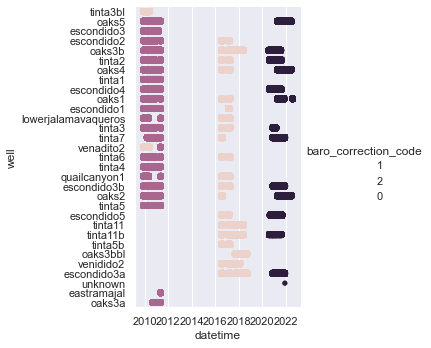

## Fixing Oaks3b

In [9]:
#Seems most remaining duplicates are from oaks3b where the higher value should be taken. Do that now. 
full_well_data.level_corrected = full_well_data.groupby(['well', 'datetime'])['level_corrected'].transform(lambda x: max(x))
full_well_data = full_well_data.drop_duplicates(subset=['well','datetime','level_corrected'])

In [10]:
full_well_data.loc[full_well_data.level_corrected.abs() > 200].well.value_counts()

escondido3b    18147
tinta7            22
tinta3            20
Name: well, dtype: int64

# Fixing Escondido 3b

In [11]:
#Escondido 3B Experienced Instrument Failure between 2016 and 2018. Remove these data points. 
full_well_data = full_well_data[~((full_well_data.well == "escondido3b") & (full_well_data.datetime > pd.to_datetime("2016-01-01")) & (full_well_data.datetime < pd.to_datetime("2018-01-01")))]

# Fixing Escondido 2

In [12]:
full_well_data = full_well_data[~((full_well_data.well=="escondido2") & (full_well_data.level_corrected < 5))]

# Fixing Tinta 3

In [13]:
full_well_data = full_well_data[~((full_well_data.well=="tinta3") & ((full_well_data.level_corrected.abs() > 80) | (full_well_data.level_corrected < 0)))]

# Fixing Tinta 7

In [14]:
full_well_data = full_well_data[~((full_well_data.well=="tinta7") & ((full_well_data.level_corrected.abs() > 80) | (full_well_data.level_corrected < 0)))]

# Renaming Venidido
Some of the levellogger files contain a typo, putting their location as venidido in lieu of venadito.

In [15]:
full_well_data.loc[full_well_data.well=="venidido2", "well"] = "venadito2"

# Fixing Oaks 3a

In [23]:
full_well_data = full_well_data[~((full_well_data.well=="oaks3a") & (full_well_data.level_corrected < 0))]

# Save Full Well Data

In [50]:
full_well_data = full_well_data[~(full_well_data.well == "unknown")]

In [30]:
full_well_data.to_csv(f"{data_dir}/full_well_data_cleaned_v1.csv")

E:\Users\jinsu.elhance\AppData\Local\ESRI\conda\envs\arcgeopy\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


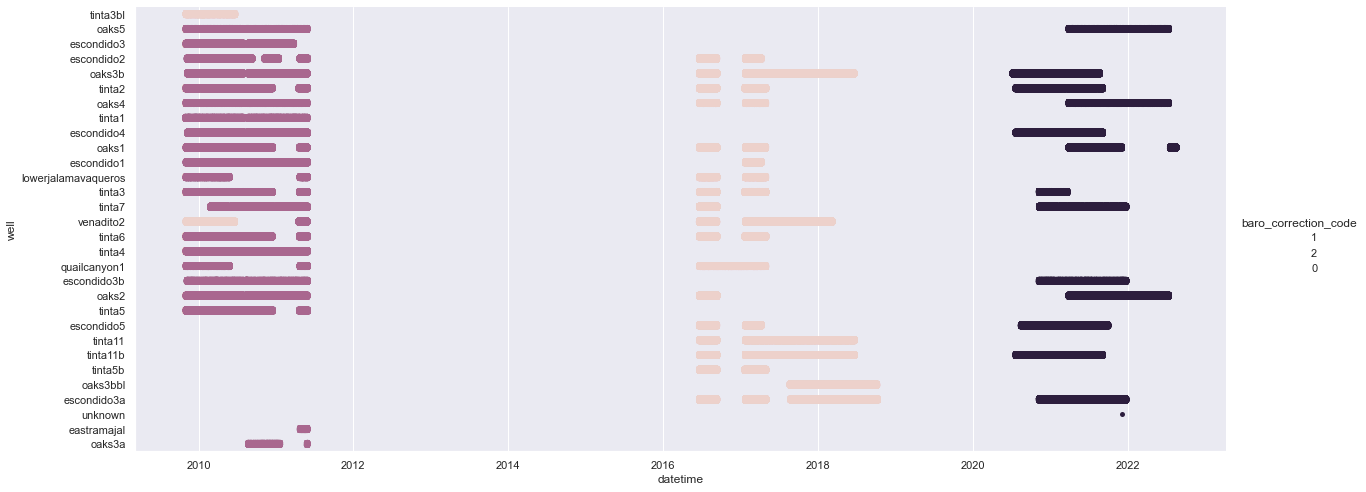

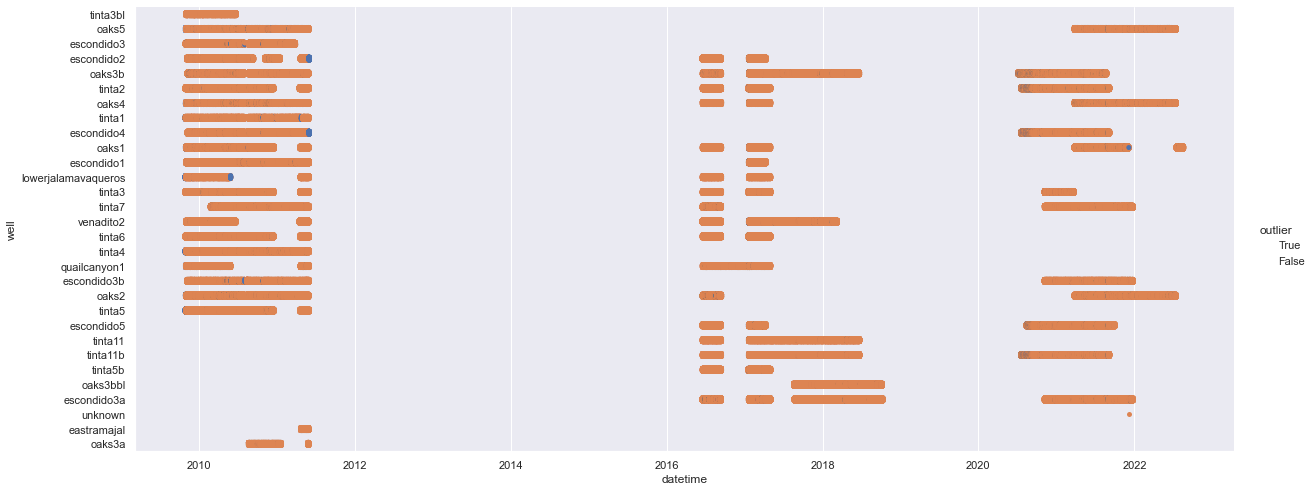

In [33]:
sns.set(rc={"figure.figsize":(6, 6)})
sns.catplot(full_well_data, x="datetime", y="well", hue="baro_correction_code", hue_order=[1,2,0], height = 7, aspect=2.5, legend_out=False);
sns.catplot(full_well_data, x="datetime", y="well", hue="outlier", hue_order=[True, False], height = 7, aspect=2.5, legend_out = False);

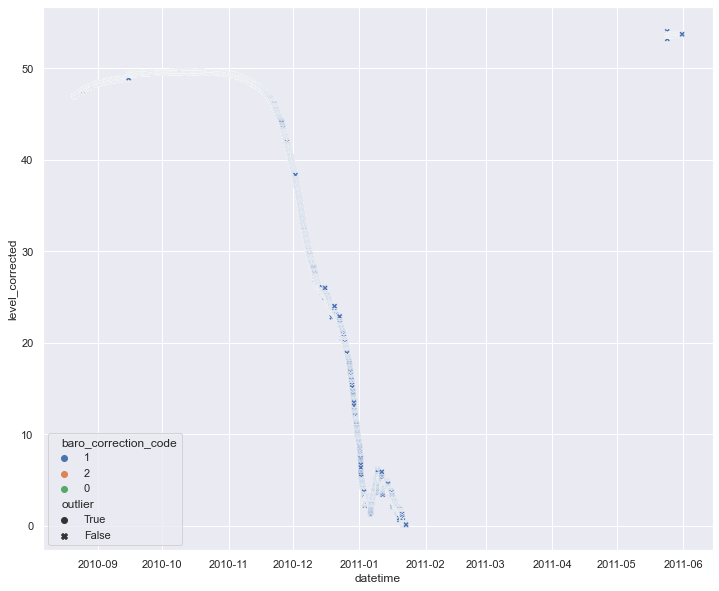

In [27]:
well = "oaks3a"
_t = full_well_data.loc[(full_well_data.well==well) & (full_well_data.datetime > pd.to_datetime("2020-01-01"))]
_nt = full_well_data.loc[(full_well_data.well==well)]
_g = sns.scatterplot(_nt, x="datetime", y="level_corrected", hue="baro_correction_code", hue_order=[1,2,0], style="outlier", style_order=[True, False])
# _g = sns.lineplot(_nt, x="datetime", y="level_corrected", hue="baro_correction_code", hue_order=[1,2,0]);
# _g.set(ylim=(0, 80))

AttributeError: 'Rectangle' object has no property 'labels'

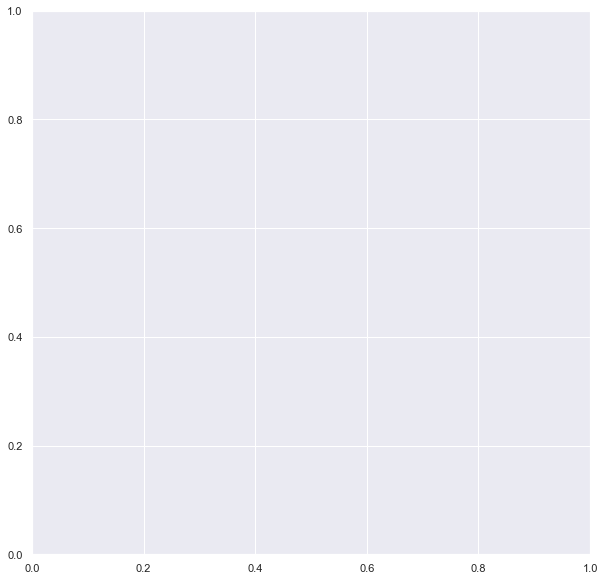

In [52]:
sns.set(rc={"figure.figsize":(10, 10)})
counts = sns.countplot(full_well_data, x="well", labels=True)
counts.set_xticklabels(counts.get_xticklabels(), rotation=90);

In [3]:
full_well_data = pd.read_csv(f"{data_dir}/full_well_data_cleaned_v1.csv")

In [6]:
full_well_data.temperature_f.isna().value_counts()

temperature_f
False    2115015
True        2973
Name: count, dtype: int64

In [14]:
test = full_well_data.loc[full_well_data.level_corrected.notna()]
test

,Unnamed: 0,well,datetime,level,level_corrected,temperature,temperature_c,temperature_f,barologger_level,barologger_level_c_elevation,temperature_barometer_f,barologger_level_lompoc,baro_correction_code,outlier
0,0,tinta3bl,2009-10-30 14:00:00,2.9364,2.936400,29.520,29.520,85.1360,NaN,NaN,NaN,NaN,0,True
1,1,tinta3bl,2009-10-30 14:15:00,2.9323,2.932300,30.145,30.145,86.2610,NaN,NaN,NaN,NaN,0,False
2,2,tinta3bl,2009-10-30 14:30:00,2.9250,2.925000,30.508,30.508,86.9144,NaN,NaN,NaN,NaN,0,False
3,3,tinta3bl,2009-10-30 14:45:00,2.9203,2.920300,30.595,30.595,87.0710,NaN,NaN,NaN,NaN,0,False
4,4,tinta3bl,2009-10-30 15:00:00,2.9186,2.918600,30.465,30.465,86.8370,NaN,NaN,NaN,NaN,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117983,2183684,oaks3a,2011-05-31 12:45:00,57.2538,53.721531,NaN,NaN,67.0982,2.8313,3.532269,76.9298,NaN,1,False
2117984,2183685,oaks3a,2011-05-31 13:00:00,57.2574,53.722331,NaN,NaN,67.1018,2.8341,3.535069,77.3510,NaN,1,False
2117985,2183686,oaks3a,2011-05-31 13:15:00,57.2584,53.719631,NaN,NaN,67.1000,2.8378,3.538769,78.0782,NaN,1,False
2117986,2183687,oaks3a,2011-05-31 13:30:00,57.2605,53.727131,NaN,NaN,67.0964,2.8324,3.533369,78.9242,NaN,1,False


In [20]:
full_well_data.loc[full_well_data.well == "oaks3b"]

,Unnamed: 0,well,datetime,level,level_corrected,temperature,temperature_c,temperature_f,barologger_level,barologger_level_c_elevation,temperature_barometer_f,barologger_level_lompoc,baro_correction_code,outlier
229316,235754,oaks3b,2017-03-08 10:02:27,33.3661,33.366100,66.506,NaN,66.5060,NaN,NaN,NaN,NaN,0,True
229317,235755,oaks3b,2017-03-08 10:17:27,74.2620,74.262000,66.131,NaN,66.1310,NaN,NaN,NaN,NaN,0,False
229318,235756,oaks3b,2017-03-08 10:32:27,74.2616,74.261600,66.141,NaN,66.1410,NaN,NaN,NaN,NaN,0,False
229319,235757,oaks3b,2017-03-08 10:47:27,74.2610,74.261000,66.154,NaN,66.1540,NaN,NaN,NaN,NaN,0,False
229320,235758,oaks3b,2017-03-08 11:02:27,74.2604,74.260400,66.124,NaN,66.1240,NaN,NaN,NaN,NaN,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380994,417174,oaks3b,2011-05-31 13:00:00,48.8127,45.277631,NaN,NaN,66.0380,2.8341,3.535069,77.3510,NaN,1,False
380995,417175,oaks3b,2011-05-31 13:15:00,48.8158,45.277031,NaN,NaN,66.0146,2.8378,3.538769,78.0782,NaN,1,False
380996,417176,oaks3b,2011-05-31 13:30:00,48.8159,45.282531,NaN,NaN,66.0056,2.8324,3.533369,78.9242,NaN,1,False
380997,417177,oaks3b,2011-05-31 13:45:00,48.8189,45.281531,NaN,NaN,66.0254,2.8364,3.537369,79.8080,NaN,1,False


In [5]:
for well in full_well_data.well.unique():
    well_data = full_well_data.loc[full_well_data.well == well]
    well_data.to_csv(f"{data_dir}/{well}/{well}_cleaned.csv")

In [17]:
full_well_data.index.name = "index"
full_well_data = full_well_data.drop(["Unnamed: 0"], axis=1)

,well,datetime,level,level_corrected,temperature,temperature_c,temperature_f,barologger_level,barologger_level_c_elevation,temperature_barometer_f,barologger_level_lompoc,baro_correction_code,outlier
index,,,,,,,,,,,,,
0,tinta3bl,2009-10-30 14:00:00,2.9364,2.936400,29.520,29.520,85.1360,NaN,NaN,NaN,NaN,0,True
1,tinta3bl,2009-10-30 14:15:00,2.9323,2.932300,30.145,30.145,86.2610,NaN,NaN,NaN,NaN,0,False
2,tinta3bl,2009-10-30 14:30:00,2.9250,2.925000,30.508,30.508,86.9144,NaN,NaN,NaN,NaN,0,False
3,tinta3bl,2009-10-30 14:45:00,2.9203,2.920300,30.595,30.595,87.0710,NaN,NaN,NaN,NaN,0,False
4,tinta3bl,2009-10-30 15:00:00,2.9186,2.918600,30.465,30.465,86.8370,NaN,NaN,NaN,NaN,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117983,oaks3a,2011-05-31 12:45:00,57.2538,53.721531,NaN,NaN,67.0982,2.8313,3.532269,76.9298,NaN,1,False
2117984,oaks3a,2011-05-31 13:00:00,57.2574,53.722331,NaN,NaN,67.1018,2.8341,3.535069,77.3510,NaN,1,False
2117985,oaks3a,2011-05-31 13:15:00,57.2584,53.719631,NaN,NaN,67.1000,2.8378,3.538769,78.0782,NaN,1,False


In [28]:
#Dendra Version:
#1. Drop Baro Correction Code
#2. Drop Outlier Column
#3. Mention UTC Offset
full_well_data_dnra = full_well_data.loc[:,"well":"barologger_level_lompoc"]
full_well_data_dnra = full_well_data_dnra[["well", "datetime", "level", "level_corrected", "barologger_level"]]

#DB NAME: JLDP_WELLS
#Table Name: JLDP_WELLS_$well (i.e. JLDP_WELLS_lower_jalama_vaqueros)


In [30]:
full_well_data_dnra.to_csv(f"{data_dir}/full_well_data_dendra_v1.csv")